***1. Neural Network Classifier with Scikit***

In [16]:
# Import libraries necessary for this step
import numpy as np
import pandas as pd
import json
import unicodedata
import sys
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [21]:
# Read json file as pandas dataframe and save it
df = pd.read_json('categorized-comments.jsonl', lines=True, nrows=559646)
df.head()

,cat,txt
0,sports,Barely better than Gabbert? He was significant...
1,sports,Fuck the ducks and the Angels! But welcome to ...
2,sports,Should have drafted more WRs.\n\n- Matt Millen...
3,sports,[Done](https://i.imgur.com/2YZ90pm.jpg)
4,sports,No!! NOO!!!!!


In [22]:
# Convert text to lowercase
df['txt'] = df['txt'].str.lower()
df.head()

,cat,txt
0,sports,barely better than gabbert? he was significant...
1,sports,fuck the ducks and the angels! but welcome to ...
2,sports,should have drafted more wrs.\n\n- matt millen...
3,sports,[done](https://i.imgur.com/2yz90pm.jpg)
4,sports,no!! noo!!!!!


In [23]:
# Create a dictionary of punctuation characters
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))

# Use the punctuation dictionary to remove all punctuation from text column
df['txt'] = [string.translate(punctuation) for string in df['txt']]
df['txt'] = df['txt'].replace("\n"," ")
df.head()

,cat,txt
0,sports,barely better than gabbert he was significantl...
1,sports,fuck the ducks and the angels but welcome to a...
2,sports,should have drafted more wrs\n\n matt millen p...
3,sports,donehttpsiimgurcom2yz90pmjpg
4,sports,no noo


In [27]:
# Load stopwords, create function to remove stopwords, and apply to text
import re
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

df['txt'] = df['txt'].apply(removeStopWords)
df.head()

,cat,txt
0,sports,barely better gabbert significantly better ...
1,sports,fuck ducks angels welcome new niners fans
2,sports,drafted wrs\n\n matt millen probably
3,sports,donehttpsiimgurcom2yz90pmjpg
4,sports,noo


In [28]:
# Create a stemming function and apply it to text
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

df['txt'] = df['txt'].apply(stemming)
df.head()

,cat,txt
0,sports,bare better gabbert signific better year 16th ...
1,sports,fuck duck angel welcom new niner fan
2,sports,draft wrs matt millen probabl
3,sports,donehttpsiimgurcom2yz90pmjpg
4,sports,noo


In [110]:
# Sample the dataset because it is very large
sample = df.sample(n=1000)

#creating sample2 and resetting the index here to fix a problem that occured with the keras model. 
# Comment this section out for MLPClassifier exercise.
sample2 = sample.reset_index()
sample2 = sample2[['cat', 'txt']]

In [137]:
# Train test split the data
from sklearn.model_selection import train_test_split

train, test = train_test_split(sample2, random_state=42, test_size=0.30, shuffle=True)

#resetting the index here to fix a problem that occured with the keras model. 
# Comment this section out for MLPClassifier exercise.
train = train.reset_index()
test = test.reset_index()

In [140]:
# Convert text to numerical vectors using Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2', max_features = 3000
)
vectorizer.fit(train['txt'])
vectorizer.fit(test['txt'])

x_train = vectorizer.transform(train['txt'])
y_train = train['cat']
x_test = vectorizer.transform(test['txt'])
y_test = test['cat']

In [49]:
# Create classifier
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=[500,150], verbose=True)

C:\Users\myraw\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


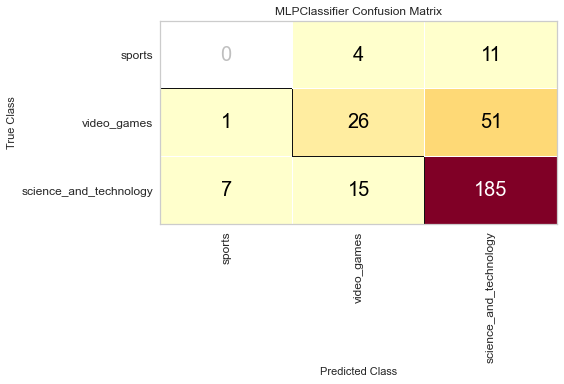

In [58]:
# fit the model and view confusion matrix results
from yellowbrick.classifier import ConfusionMatrix

classes = ['sports', 'video_games', 'science_and_technology']
cm = ConfusionMatrix(clf, classes=classes, percent=False)
cm.fit(x_train, y_train)

# Use the test data to make predictions and score the results
cm.score(x_test, y_test)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

cm.poof()

C:\Users\myraw\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


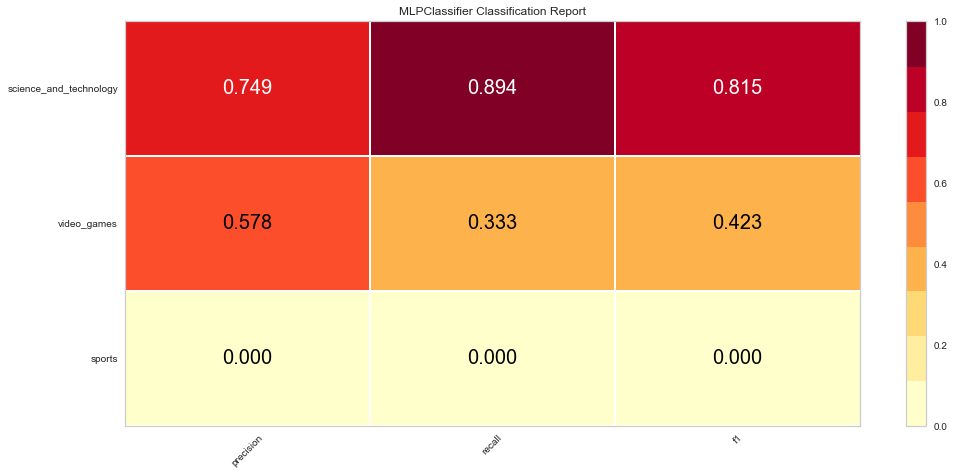

In [60]:
# Check the Precision, Recall, and F1 Score
import matplotlib.pyplot as plt

# import libraries
from yellowbrick.classifier import ClassificationReport

# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(clf, classes=classes)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

***2. Neural Network Classifier with Keras***

In [141]:
# In order for keras model to run, change format from sparse to dense matrix
x_train2 = x_train.todense()
x_test2 = x_test.todense()

In [94]:
# Import necessary libraries and create build_network function
from keras.layers import Dense
from keras.models import Sequential

N_FEATURES = 3000
N_CLASSES = 3

def build_network():
    nn = Sequential()
    nn.add(Dense(500, activation='relu', input_shape=(N_FEATURES,)))
    nn.add(Dense(150, activation='relu'))
    nn.add(Dense(N_CLASSES, activation='softmax')),
    nn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return nn

In [95]:
# Create classifier
from keras.wrappers.scikit_learn import KerasClassifier
kf = KerasClassifier(build_fn=build_network, epochs=200, batch_size=128)

In [142]:
kf.fit(x_train2, y_train)

Epoch 1/200
6/6 [==============================] - 0s 12ms/step - loss: 1.0518 - accuracy: 0.6080
Epoch 2/200
6/6 [==============================] - 0s 13ms/step - loss: 0.8613 - accuracy: 0.6837
Epoch 3/200
6/6 [==============================] - 0s 13ms/step - loss: 0.6896 - accuracy: 0.7167
Epoch 4/200
6/6 [==============================] - 0s 13ms/step - loss: 0.6824 - accuracy: 0.6840
Epoch 5/200
6/6 [==============================] - 0s 13ms/step - loss: 0.6106 - accuracy: 0.6917
Epoch 6/200
6/6 [==============================] - 0s 13ms/step - loss: 0.5378 - accuracy: 0.7108
Epoch 7/200
6/6 [==============================] - 0s 13ms/step - loss: 0.4898 - accuracy: 0.7149
Epoch 8/200
6/6 [==============================] - 0s 12ms/step - loss: 0.4289 - accuracy: 0.8049
Epoch 9/200
6/6 [==============================] - 0s 14ms/step - loss: 0.3807 - accuracy: 0.8714
Epoch 10/200
6/6 [==============================] - 0s 14ms/step - loss: 0.3123 - accuracy: 0.9001
Epoch 11/200
6/6 [=

Epoch 83/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1030 - accuracy: 0.9477
Epoch 84/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1090 - accuracy: 0.9470
Epoch 85/200
6/6 [==============================] - 0s 13ms/step - loss: 0.1044 - accuracy: 0.9562
Epoch 86/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1081 - accuracy: 0.9481
Epoch 87/200
6/6 [==============================] - 0s 13ms/step - loss: 0.1055 - accuracy: 0.9535
Epoch 88/200
6/6 [==============================] - 0s 12ms/step - loss: 0.1145 - accuracy: 0.9499
Epoch 89/200
6/6 [==============================] - 0s 13ms/step - loss: 0.1056 - accuracy: 0.9543
Epoch 90/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0943 - accuracy: 0.9562
Epoch 91/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0993 - accuracy: 0.9575
Epoch 92/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0890 - accuracy: 0.9600
Epoch 93/2

6/6 [==============================] - 0s 13ms/step - loss: 0.0926 - accuracy: 0.9615
Epoch 166/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1148 - accuracy: 0.9465
Epoch 167/200
6/6 [==============================] - 0s 13ms/step - loss: 0.1153 - accuracy: 0.9454
Epoch 168/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1225 - accuracy: 0.9434
Epoch 169/200
6/6 [==============================] - 0s 13ms/step - loss: 0.1099 - accuracy: 0.9537
Epoch 170/200
6/6 [==============================] - 0s 13ms/step - loss: 0.1068 - accuracy: 0.9520
Epoch 171/200
6/6 [==============================] - 0s 12ms/step - loss: 0.1107 - accuracy: 0.9475
Epoch 172/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1128 - accuracy: 0.9483
Epoch 173/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0953 - accuracy: 0.9564
Epoch 174/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1031 - accuracy: 0.9495
Epoch 175/200


In [145]:
# Because Yellowbrick would not work with my data, I used the following method to print the confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, precision_recall_fscore_support
nn_mod_predict = kf.predict(x_test2)
confusion_matrix(y_test, nn_mod_predict)

array([[  4,   1,   9],
       [  0,  35,  47],
       [  4,  33, 167]], dtype=int64)

In [156]:
# Calculate metrics on my model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, 

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, nn_mod_predict)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, nn_mod_predict, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, nn_mod_predict, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, nn_mod_predict, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.686667
Precision: 0.671218
Recall: 0.686667
F1 score: 0.675577


In [163]:
# print precision, recall, F1-score per each class/tag
from sklearn.metrics import classification_report
print(classification_report(y_test, nn_mod_predict))

                        precision    recall  f1-score   support

science_and_technology       0.50      0.29      0.36        14
                sports       0.51      0.43      0.46        82
           video_games       0.75      0.82      0.78       204

              accuracy                           0.69       300
             macro avg       0.59      0.51      0.54       300
          weighted avg       0.67      0.69      0.68       300



***3. Classifying Images***

In [ ]:
In chapter 20 of the Machine Learning with Python Cookbook, implement the code found in section 20.15 classify MSINT 
images using a convolutional neural network. Report the accuracy of your results.

In [1]:
# Import libraries
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [26]:
# Set the color channel value
K.set_image_data_format('channels_last')

In [3]:
# Set seed
np.random.seed(0)

In [4]:
# Set image information
channels = 1
height = 28
width = 28

In [27]:
# Load data and target from MNist
(data_train, target_train), (data_test, target_test) = mnist.load_data()

In [28]:
# Reshape training image data into features
data_train = data_train.reshape(data_train.shape[0], height, width, channels)

# Reshape test image data into features
data_test = data_test.reshape(data_test.shape[0], height, width, channels)

In [29]:
# Rescale pixel intensity to between 0 and 1
features_train = data_train / 255
features_test = data_test / 255

In [30]:
# Ond-hot encode target
target_train = np_utils.to_categorical(target_train)
target_test = np_utils.to_categorical(target_test)
number_of_classes = target_test.shape[1]

In [31]:
# Build the neural network
network = Sequential()

# Add convolutional layer
network.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(height, width, channels), activation='relu'))
network.add(MaxPooling2D(pool_size=(2, 2))) # Add max pooling layer
network.add(Dropout(0.5)) # Add dropout layer
network.add(Flatten()) # Add layer to flatten input
network.add(Dense(128, activation='relu')) # Add fully connected layer with ReLU function
network.add(Dropout(0.5)) # Add dropout layer
network.add(Dense(number_of_classes, activation='softmax')) # Add fully connected layer with softmax function

# Compile neural network
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [32]:
# Train neural network
network.fit(features_train, target_train, epochs=2, verbose=0, batch_size=1000, validation_data=(features_test, target_test))

In [37]:
# Evaluate the model
test_eval = network.evaluate(features_test, target_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.09573258459568024
Test accuracy: 0.97079998254776
